## Conv 연산
- Hout = ⌞(Hin + 2 * padding - dilation * (kenel_size - 1) - 1) / stride + 1⌟ 
  + ⌞x⌟ : x 보다 작으면서 가장 가까운 정수를 return

## Transposec conv 연산
- Hout = (Hin - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

### (1) Import

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Image class 정의

In [32]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# horse2zebra 폴더가 존재할 것
# trainZ, trainB, testA, testB 폴더가 존재할 것
class ImageDataset(Dataset):
  def __init__(self, root, transform=None, mode='train'):
    self.transform = transform
    self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
    self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
    if len(self.files_A) > len(self.files_B):
      self.files_A, self.files_B = self.files_B, self.files_A
    self.new_perm()
    assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

  def new_perm(self):
    self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

  def __getitem__(self, index):
    item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
    item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
    if item_A.shape[0] != 3:
      item_A = item_A.repeat(3, 1, 1)
    if item_B.shape[0] != 3:
      item_B = item_B.repeat(3, 1, 1)
    if index == len(self) - 1:
      self.new_perm()
    # old versions of pytorch didn't support normalization for different-channeled images 
    return (item_A - 0.5) * 2, (item_B - 0.5) * 2

  def __len__(self):
    return min(len(self.files_A), len(self.files_B))


### (3) generator

### (3-1) Featuremap block
- 1번의 convolution 연산을 통해서 영상의 해상도는 유지하면서 channel을 변
화시킴
- upfeature module: 3 channels -> 64 channels
- downfeature module: 64 channels -> 3 channels

In [33]:
class FeatureMapBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(FeatureMapBlock, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

  def forward(self, x):
    x = self.conv(x)
    return x

### (3-2) Contractor block
- 이전 영상의 해상도를 ½로 줄이면서 channel의 수를 2배로 증가

In [34]:
class ContractingBlock(nn.Module):
  def __init__(self, input_channels, use_bn=True, activation='relu'):
    super(ContractingBlock, self).__init__()

    # 해상도를 반으로 줄이는 공식(stride = 2를 주는 것이 정석)
    # ⌞(Hin + 2 * padding - dilation * (kenel_size-1) - 1) / stride + 1⌟
    # ⌞(Hin + 2 * 1 - 1 * (3 - 1) - 1) / 2 + 1⌟ = ⌞(Hin + 2 - 2 - 1) / 2 + 1⌟ = ⌞(Hin - 1) / 2 + 1⌟ = ⌞Hin / 2 + 0.5⌟ = Hin / 2 (floor 함수로 인해 소수점은 버리게 됨)
    self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1, stride=2, padding_mode='reflect') # padding_mode='reflect' : 바깥쪽에 있는 부분을 복사해서 붙인다.

    self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
    if use_bn:
      self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
    self.use_bn = use_bn

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.instancenorm(x)
    x = self.activation(x)
    return x

### (3-3) Residual block
- 이전 영상의 크기를 유지하면서 conv 연산을 수행하고, 그 결과 영상과 입력
영상을 concatenation
- skip-connection 역할을 residual block이 수행한다고 생각

In [35]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels):
    super(ResidualBlock, self).__init__()
    
    # 영상의 크기를 유지
    # ⌞(Hin + 2 * padding - dilation * (kenel_size - 1) - 1) / stride + 1⌟
    # ⌞(Hin + 2 * 1 - 1 * (3 - 1) - 1) / 1 + 1⌟ = ⌞(Hin + 2 - 2 - 1) / 1 + 1⌟ = Hin
    self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, stride=1, padding_mode='reflect') 
    self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, stride=1, padding_mode='reflect') 

    # 두 개의 Conv2d 를 만드는 이유? 
    # neural network 는 파라미터를 학습시키는 게 중요한데, 각각 2개의 필터를 만들어서 독립적으로 학습을 시킨다는 의미이다. 
    # residual block 에서는 2번의 convolution 계산을 하고 각각 독립적으로 학습을 시키겠다는 의미이다.

    self.instancenorm = nn.InstanceNorm2d(input_channels)
    self.activation = nn.ReLU()

  def forward(self, x):
    original_x = x.clone()
    x = self.conv1(x)
    x = self.instancenorm(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.instancenorm(x)
    return original_x + x

### (3-4) Expander block
- 이전 영상의 해상도를 2배로 늘이면서 channel의 수를 ½ 배로 감소

In [50]:
class ExpandingBlock(nn.Module):
  def __init__(self, input_channels, use_bn=True):
    super(ExpandingBlock, self).__init__()

    # 채널의 수를 반으로 나누기 위해 몫 나누기를 사용
    # 영상의 해상도를 2배로 늘이기 위해 kernel_size = 3 / stride가 영상의 크기를 결정
    # (Hin - 1) * 2 - 2 * 1 + 1 * (3 - 1) + output_padding + 1 = 2Hin - 2 - 2 + 2 + output_padding + 1 = 2Hin - 1 + output_padding
    # 따라서, output_padding = 1 을 줘야 영상의 해상도를 2배로 늘릴 수 있다. 
    self.conv1 = nn.ConvTranspose2d(input_channels, input_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1) 

    if use_bn:
      self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
    self.use_bn = use_bn
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.instancenorm(x)
    x = self.activation(x)
    return x

In [51]:
class Generator(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels=64):
    super(Generator, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels)
    self.contract2 = ContractingBlock(hidden_channels*2)
    res_mult = 4
    self.res0 = ResidualBlock(hidden_channels * res_mult)
    self.res1 = ResidualBlock(hidden_channels * res_mult)
    self.res2 = ResidualBlock(hidden_channels * res_mult)
    self.res3 = ResidualBlock(hidden_channels * res_mult)
    self.res4 = ResidualBlock(hidden_channels * res_mult)
    self.res5 = ResidualBlock(hidden_channels * res_mult)
    self.res6 = ResidualBlock(hidden_channels * res_mult)
    self.res7 = ResidualBlock(hidden_channels * res_mult)
    self.res8 = ResidualBlock(hidden_channels * res_mult)
    self.expand2 = ExpandingBlock(hidden_channels * 4)
    self.expand3 = ExpandingBlock(hidden_channels * 2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
    self.tanh = torch.nn.Tanh()

  # 0, 1, 2... 이걸 다 떼고, 즉 모두 x로 해도 돌아가는데 가동성을 위해 다음과 같이 설정함
  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.res0(x2)
    x4 = self.res1(x3)
    x5 = self.res2(x4)
    x6 = self.res3(x5)
    x7 = self.res4(x6)
    x8 = self.res5(x7)
    x9 = self.res6(x8)
    x10 = self.res7(x9)
    x11 = self.res8(x10)
    x12 = self.expand2(x11)
    x13 = self.expand3(x12) 
    xn = self.downfeature(x13)

    return self.tanh(xn)

### (4) Discriminator

In [52]:
class Discriminator(nn.Module):
  def __init__(self, input_channels, hidden_channels=64):
    super(Discriminator, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels, use_bn=False, activation='lrelu')
    self.contract2 = ContractingBlock(hidden_channels*2, activation='lrelu')
    self.contract3 = ContractingBlock(hidden_channels*4, activation='lrelu')
    self.final = nn.Conv2d(hidden_channels*8, 1, kernel_size=1)

  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    xn = self.final(x3)

    return xn

### (5) 초기화

### (5-1) 변수 초기화

In [53]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cpu'

### (5-2) 데이터 로딩

In [54]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("./drive/MyDrive/dataset3/horse2zebra", transform=transform)

### (5-3) optimizer

In [55]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

### (6) Discriminator loss

In [63]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
  # disc_X를 가지고 fake_X를 해라. generator 에서만 미분 / detach() : 미분을 안 한다.
  disc_fake_X_hat = disc_X(fake_X.detach()) # Dh(Gzh(x))

  # Ex~z[(D-0)^2]
  # adv_criterion = Ex~z
  disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
  disc_real_X_hat = disc_X(real_X) # Dh(y), real_X = y 이다.

  # Ey~H[(Dh(y) - 1)^2]
  disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
  disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2

  return disc_loss

### (7) Generator loss

### (7-1) Adversarial loss

In [64]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
  fake_Y = gen_XY(real_X) # X를 받아서 Y를 만들기, 미분도 할 예정 => Gzh(x)
  disc_fake_Y_hat = disc_Y(fake_Y) # D(Gzh(X))
  adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat)) # 1과 비교하여 그 차이를 adv_criterion

  return adversarial_loss, fake_Y

### (7-2) Cycle consistency loss
- H -> Z -> H에 대한 loss와 Z -> H -> Z에 대한 loss를 고려

In [65]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
  # fake_Y 로 시작하므로 fake_Y = gen_XY(real_X) 이 과정이 필요 없음
  cycle_X = gen_YX(fake_Y)
  cycle_loss = cycle_criterion(cycle_X, real_X)

  return cycle_loss, cycle_X

### (7-3) identity loss
- 색의 차이가 발생하는 경우가 많음

In [66]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
  identity_X = gen_YX(real_X)
  identity_loss = identity_criterion(identity_X, real_X)

  return identity_loss, identity_X

### (7-4) Total loss

In [67]:
# GAN loss와 cycle loss를 함께 고려해야 좋은 결과가 나옴
# identity loss는 원본의 색을 유지하도록 함

def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
  #Adversarial Loss
  adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A , gen_BA, adv_criterion)
  adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
  gen_adversarial_loss = adv_loss_BA + adv_loss_AB
  
  # Identity Loss
  identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
  identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
  gen_identity_loss = identity_loss_A + identity_loss_B

  #Cycle-consistency Loss
  cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
  cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion )
  gen_cycle_loss = cycle_loss_BA +cycle_loss_AB

  #Total loss
  gen_loss = lambda_identity + gen_identity_loss + lambda_cycle + gen_cycle_loss + gen_adversarial_loss

  return gen_loss, fake_A, fake_B

### (8) Image display 함수

In [70]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  '''
  Function for visualizing images : Given a tensor of images, number of images,
  and size per image, plots and prints the images in an uniform grid.
  '''
  image_tensor = (image_tensor + 1) / 2
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

### (9) training

Epoch : 0, Step : 0, Generator(U-Net) loss : 0.07451093673706055, Discriminator loss : 0.00458036482334137


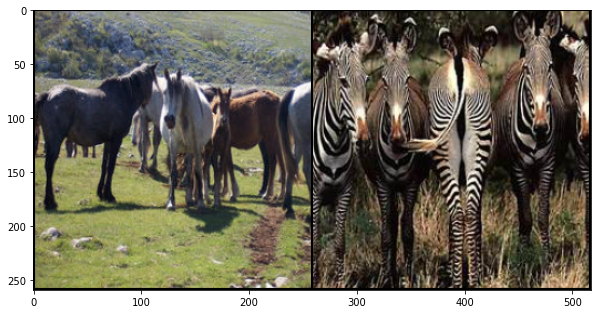

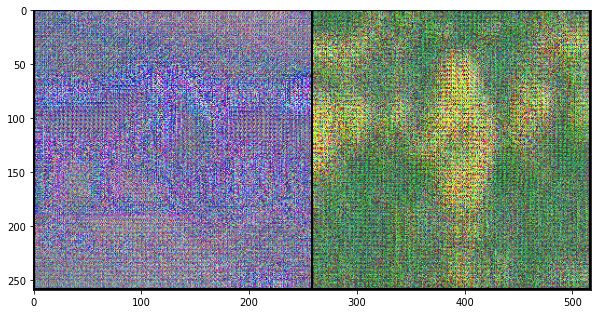

KeyboardInterrupt: ignored

In [71]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

def train(save_model=False):
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  cur_step = 0

  for epoch in range(n_epochs):
    # Dataloader returns the batches
    # for image, _ in tqdm(dataloader):
    for real_A, real_B in tqdm(dataloader):
      # image_width = image.shape[3]
      real_A = nn.functional.interpolate(real_A, size=target_shape)
      real_B = nn.functional.interpolate(real_B, size=target_shape)
      cur_batch_size = len(real_A)
      real_A = real_A.to(device)
      real_B = real_B.to(device)

      ## update discriminator A ## 
      disc_A_opt.zero_grad() # zero out the gradient before backpropagation
      with torch.no_grad():
        fake_A = gen_BA(real_B)
      disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
      disc_A_loss.backward(retain_graph=True) # update gradients
      disc_A_opt.step() # update optimizer

      ## update discriminator B ## 
      disc_B_opt.zero_grad() # zero out the gradient before backpropagation
      with torch.no_grad():
        fake_B = gen_AB(real_A)
      disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
      disc_B_loss.backward(retain_graph=True) # update gradients
      disc_B_opt.step() # update optimizer

      ## update generator ##
      gen_opt.zero_grad()
      gen_loss, fake_A, fake_B = get_gen_loss(
          real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
      )
      gen_loss.backward() # update gradients
      gen_opt.step() # update optimizer

      # keep track of the average discriminator loss
      mean_discriminator_loss += disc_A_loss.item() / display_step
      # keep track of the average generator loss
      mean_generator_loss += gen_loss.item() / display_step

      ## visualization code ##
      if cur_step % display_step == 0:
        print(f"Epoch : {epoch}, Step : {cur_step}, Generator(U-Net) loss : {mean_generator_loss}, Discriminator loss : {mean_discriminator_loss}")
        show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
        show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        
        # you can change save_model to True if you'd like to save save the model
        if save_model:
          torch.save({
              'gen_AB' : gen_AB.state_dict(),
              'gen_BA' : gen_BA.state_dict(),
              'gen_opt' : gen_opt.state_dict(),
              'disc_A' : disc_A.state_dict(),
              'disc_A_opt' : disc_A_opt.state_dict(),
              'disc_B' : disc_B.state_dict(),
              'disc_B_opt' : disc_B_opt.state_dict()
          }, f"cycleGAN_{cur_step}.pth")
      
      cur_step += 1

train()